In [1]:
import sys
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "0"
sys.path.append(".")
# os.environ["MAX_JOBS"] = "100"

import torch
torch.set_printoptions(linewidth=200, threshold=100000)
torch.cuda.is_available()

from tqdm import tqdm
import matplotlib.pyplot as plt
from plot_utils import plot_numerical_diffs

In [2]:
from src.vlstm_fwbw_v2.interface import vlstm_fwbw_torch_autogradbw
from src.vlstm_fwbw_v2.interface import vlstm_fw_torch, vlstm_fw_cuda
from src.vlstm_fwbw_v2.interface import vlstm_bw_torch_obw, vlstm_bw_cuda

INCLUDE: ['/home/max/miniconda3/envs/xlstmpt220cu121/lib/python3.11/site-packages/torch/include', '/home/max/miniconda3/envs/xlstmpt220cu121/lib/python3.11/site-packages/torch/include/torch/csrc/api/include', '/home/max/miniconda3/envs/xlstmpt220cu121/lib/python3.11/site-packages/torch/include/TH', '/home/max/miniconda3/envs/xlstmpt220cu121/lib/python3.11/site-packages/torch/include/THC', '/home/max/miniconda3/envs/xlstmpt220cu121/include']
/home/max/myrepos/vlstm_cuda/src
/home/max/cpplibs/libtorch/lib:/usr/local/cuda-12.3/lib64:
/home/max/miniconda3/envs/xlstmpt220cu121/lib


Using /home/max/.cache/torch_extensions/py311_cu121 as PyTorch extensions root...
Detected CUDA files, patching ldflags
Emitting ninja build file /home/max/.cache/torch_extensions/py311_cu121/vlstm_fwbw_v2/build.ninja...
Building extension module vlstm_fwbw_v2...
Allowing ninja to set a default number of workers... (overridable by setting the environment variable MAX_JOBS=N)


## CUDA vLSTM forward-backward 

Choose large tile sizes.

### Get gpu_info

In [ ]:
from src.gpu_info.gpu_info import get_gpu_info

In [ ]:
# get_gpu_info(0)

### define inputs

In [ ]:
S = 64 #32 #32 #16 #8 # seq len
B = 1 # batch size
NH = 1 # num heads
DH = 64 # dim per head
DTYPE = torch.float32
DEVICE = torch.device("cuda:0")

In [ ]:
# create qkv, inputgates, forgetgates 
torch.manual_seed(1) #TODO from here: with seed=0 even the pytorch version alone breaks for float16 and bfloat16
# fixed:
# qs = torch.arange((B*NH*S*DH), device=DEVICE, dtype=DTYPE).reshape((B, NH, S, DH)) / 10.
# ks = torch.ones((B, NH, S, DH), device=DEVICE, dtype=DTYPE) / 100.
# vs = torch.ones((B, NH, S, DH), device=DEVICE, dtype=DTYPE) / 100.

# random: 
qs = torch.randn((B, NH, S, DH), device=DEVICE, dtype=DTYPE)
ks = torch.randn((B, NH, S, DH), device=DEVICE, dtype=DTYPE)
vs = torch.randn((B, NH, S, DH), device=DEVICE, dtype=DTYPE)
# igs = (1. + torch.arange((B * NH * S), device=DEVICE, dtype=DTYPE)).reshape(B, NH, S, 1) / 10.
# igs = torch.zeros((B, NH, S, 1), device=DEVICE, dtype=DTYPE) #/ 10.
igs = torch.randn((B, NH, S, 1), device=DEVICE, dtype=DTYPE) #/ 10.
# fgs = torch.ones((B, NH, S, 1), device=DEVICE, dtype=DTYPE)
fgs = torch.randn((B, NH, S, 1), device=DEVICE, dtype=DTYPE)

dHs = torch.randn((B, NH, S, DH), device=DEVICE, dtype=DTYPE)

In [ ]:
# inputs float16
dtype_fp16 = torch.float16
qs_half = qs.to(dtype=dtype_fp16)
ks_half = ks.to(dtype=dtype_fp16)
vs_half = vs.to(dtype=dtype_fp16)
igs_half = igs.to(dtype=dtype_fp16)
fgs_half = fgs.to(dtype=dtype_fp16)
dHs_half = dHs.to(dtype=dtype_fp16)

In [ ]:
# inputs bfloat16
dtype_bf16 = torch.bfloat16
qs_bf16 = qs.to(dtype=dtype_bf16)
ks_bf16 = ks.to(dtype=dtype_bf16)
vs_bf16 = vs.to(dtype=dtype_bf16)
igs_bf16 = igs.to(dtype=dtype_bf16)
fgs_bf16 = fgs.to(dtype=dtype_bf16)
dHs_bf16 = dHs.to(dtype=dtype_bf16)

### compare errors pure pytorch

In [ ]:
hs_pt, n_pt, m_pt, _, matLogD_pt, matD_pt = vlstm_fw_torch(queries=qs, keys=ks, values=vs, igate_preact=igs, fgate_preact=fgs)

In [ ]:
hs_pt_half, n_pt_half, m_pt_half, _, matLogD_pt_half, matD_pt_half = vlstm_fw_torch(queries=qs_half, keys=ks_half, values=vs_half, igate_preact=igs_half, fgate_preact=fgs_half)

In [ ]:
hs_pt_bf16, n_pt_bf16, m_pt_bf16, _, matLogD_pt_bf16, matD_pt_bf16 = vlstm_fw_torch(queries=qs_bf16, keys=ks_bf16, values=vs_bf16, igate_preact=igs_bf16, fgate_preact=fgs_bf16)

In [ ]:
FW_RTOL = 1e-10
FW_ATOL = 1e-4
BW_RTOL = FW_ATOL
BW_ATOL = FW_ATOL
print(f"====== Full -> Half ======")
print(f"fw hs match: {torch.allclose(hs_pt_half.float(), hs_pt, rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(hs_pt_half - hs_pt))}")
print(f"fw n match: {torch.allclose(n_pt_half.float(), n_pt, rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(n_pt_half - n_pt))}")
print(f"fw m match: {torch.allclose(m_pt_half.float(), m_pt, rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(m_pt_half - m_pt))}")
print(f"fw D match: {torch.allclose((matD_pt_half.float() - matD_pt).tril(), torch.zeros_like((matD_pt)), rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max((matD_pt_half.float() - matD_pt).tril())}")

print(f"====== Full -> bfloat16 ======")
print(f"fw hs match: {torch.allclose(hs_pt_bf16.float(), hs_pt, rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(hs_pt_bf16 - hs_pt))}")
print(f"fw n match: {torch.allclose(n_pt_bf16.float(), n_pt, rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(n_pt_bf16 - n_pt))}")
print(f"fw m match: {torch.allclose(m_pt_bf16.float(), m_pt, rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(m_pt_bf16 - m_pt))}")
print(f"fw D match: {torch.allclose((matD_pt_bf16.float() - matD_pt).tril(), torch.zeros_like((matD_pt)), rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max((matD_pt_bf16.float() - matD_pt).tril())}")


====== Full -> Half ======
fw hs match: False, max diff: 0.1732926368713379
fw n match: False, max diff: 0.07650995254516602
fw m match: False, max diff: 0.0532890260219574
fw D match: False, max diff: 0.02229440212249756
====== Full -> bfloat16 ======
fw hs match: False, max diff: 3.281093120574951
fw n match: False, max diff: 1.322603702545166
fw m match: False, max diff: 0.42647314071655273
fw D match: False, max diff: 0.24758583307266235


### match directly

In [ ]:
# cuda kernel float32
# hs_cu, n_cu, m_cu, matD_cu = vlstm_fw_cuda(mat_Q=qs, mat_K=ks, mat_V=vs, vec_igp=igs, vec_fgp=fgs)

In [ ]:
hs_cu = hs_pt
n_cu = n_pt
m_cu = m_pt
matD_cu = matD_pt

: 

In [ ]:
# cuda kernel float16
hs_cu_half, n_cu_half, m_cu_half, matD_cu_half = vlstm_fw_cuda(mat_Q=qs_half, mat_K=ks_half, mat_V=vs_half, vec_igp=igs_half, vec_fgp=fgs_half)

In [ ]:
# cuda kernel bfloat16
hs_cu_bf16, n_cu_bf16, m_cu_bf16, matD_cu_bf16 = vlstm_fw_cuda(mat_Q=qs_bf16, mat_K=ks_bf16, mat_V=vs_bf16, vec_igp=igs_bf16, vec_fgp=fgs_bf16)

before kernel dispatch - bfloat16!
B: 1, NH: 1, S: 128, DH: 64
blocksxy: 1-1, threadsxy: 256-1, QtileDim: 128, KVtileDim: 64, shared_mem in bytes (DEBUG): 90496, shared_mem in bytes (REAL): 73088
In FW-Kernel: gdim.x: 1, gdim.y: 1, gdim.z: 1, bdim.x: 256, bdim.y: 1
In FW-Kernel: QtileDim: 128, KVtileDim: 64, TblockDim:16
Bxy(0,0),Tidx:0,w-l:0-0|rgTidXY(0,0)|qIdx(0): qWTLoopXY(0,0), qWTSmemXY(0,0)
Bxy(0,0),Tidx:1,w-l:0-1|rgTidXY(1,0)|qIdx(0): qWTLoopXY(0,0), qWTSmemXY(0,0)
Bxy(0,0),Tidx:8,w-l:0-8|rgTidXY(0,2)|qIdx(0): qWTLoopXY(0,0), qWTSmemXY(0,2)
Bxy(0,0),Tidx:9,w-l:0-9|rgTidXY(1,2)|qIdx(0): qWTLoopXY(0,0), qWTSmemXY(0,2)
Bxy(0,0),Tidx:0,w-l:0-0|rgTidXY(0,0)|qIdx(0): qWTLoopXY(1,0), qWTSmemXY(32,0)
Bxy(0,0),Tidx:1,w-l:0-1|rgTidXY(1,0)|qIdx(0): qWTLoopXY(1,0), qWTSmemXY(32,0)
Bxy(0,0),Tidx:8,w-l:0-8|rgTidXY(0,2)|qIdx(0): qWTLoopXY(1,0), qWTSmemXY(32,2)
Bxy(0,0),Tidx:9,w-l:0-9|rgTidXY(1,2)|qIdx(0): qWTLoopXY(1,0), qWTSmemXY(32,2)
Bxy(0,0),Tidx:0,w-l:0-0|rgTidXY(0,0)|qIdx(0): qWTLoopXY(0

In [ ]:
hs_cu_half.shape, qs_half.shape

(torch.Size([1, 1, 128, 64]), torch.Size([1, 1, 128, 64]))

In [ ]:
qs_half

tensor([[[[-2.9639e-01,  2.6758e+00, -1.4087e-01, -8.4424e-01,  2.9053e-01, -2.8394e-01, -1.4531e+00,  2.3730e+00, -1.7746e-02, -2.7891e+00, -3.7891e-01,  7.0459e-01, -1.3955e+00, -1.2476e-01,
           -9.2578e-01, -1.5459e+00, -4.9023e-01,  2.4368e-02, -1.5996e+00, -8.4668e-01, -8.3740e-01, -6.3623e-01, -1.2969e+00, -4.6021e-01,  1.7468e-01,  1.3145e+00,  2.6797e+00,  1.5586e+00,
            4.0503e-01,  1.8640e-01, -1.5410e+00,  1.3428e+00,  5.7324e-01,  2.7802e-02,  1.2970e-02, -2.7715e+00,  3.7793e-01, -2.4768e-01,  6.6992e-01,  1.9268e+00,  9.8083e-02,  9.1943e-01,
            8.8074e-02, -1.1420e-01,  2.3008e+00, -2.8491e-01,  7.5830e-01,  1.1572e+00, -1.0908e+00, -1.2457e-01,  3.6133e-01,  8.5010e-01, -1.0762e+00, -2.9492e-01, -9.9561e-01, -4.8779e-01,
           -2.8564e-01, -6.9141e-01, -9.3750e-01, -1.9821e-02,  5.8154e-01, -8.5254e-01,  3.5596e-01, -1.3682e+00],
          [-1.4365e+00, -1.5195e+00,  2.2913e-01, -1.3489e-01, -1.9434e+00,  1.7119e+00, -3.7964e-01, -1.2852e+0

In [ ]:
FW_RTOL = 1e-10
FW_ATOL = 1e-4
BW_RTOL = FW_ATOL
BW_ATOL = FW_ATOL
print(f"Match against pt float32:")
print(f"====== Full ======")
print(f"fw hs match: {torch.allclose(hs_cu, hs_pt, rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(hs_cu - hs_pt))}")
print(f"fw n match: {torch.allclose(n_cu, n_pt, rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(n_cu - n_pt))}")
print(f"fw m match: {torch.allclose(m_cu, m_pt, rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(m_cu - m_pt))}")
print(f"fw D match: {torch.allclose((matD_cu - matLogD_pt).tril(), torch.zeros_like((matD_cu)), rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max((matD_cu - matLogD_pt).tril())}")

print(f"====== Half ======")
print(f"fw hs match: {torch.allclose(hs_cu_half.float(), hs_pt, rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(hs_cu_half - hs_pt))}")
print(f"fw n match: {torch.allclose(n_cu_half.float(), n_pt, rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(n_cu_half - n_pt))}")
print(f"fw m match: {torch.allclose(m_cu_half.float(), m_pt, rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(m_cu_half - m_pt))}")
print(f"fw D match: {torch.allclose((matD_cu_half.float() - matLogD_pt).tril(), torch.zeros_like((matLogD_pt)), rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max((matD_cu_half - matLogD_pt).tril())}")

print(f"====== bfloat16 ======")
print(f"fw hs match: {torch.allclose(hs_cu_bf16.float(), hs_pt, rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(hs_cu_bf16 - hs_pt))}")
print(f"fw n match: {torch.allclose(n_cu_bf16.float(), n_pt, rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(n_cu_bf16 - n_pt))}")
print(f"fw m match: {torch.allclose(m_cu_bf16.float(), m_pt, rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(m_cu_bf16 - m_pt))}")
print(f"fw D match: {torch.allclose((matD_cu_bf16.float() - matLogD_pt).tril(), torch.zeros_like((matLogD_pt)), rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max((matD_cu_bf16 - matLogD_pt).tril())}")


Match against pt float32:
====== Full ======
fw hs match: True, max diff: 0.0
fw n match: True, max diff: 0.0
fw m match: True, max diff: 0.0
fw D match: False, max diff: 105.7960205078125
====== Half ======
fw hs match: False, max diff: 7.5410051345825195
fw n match: False, max diff: 3.7951691150665283
fw m match: False, max diff: 2.3591573238372803
fw D match: False, max diff: 105.7960205078125
====== bfloat16 ======
fw hs match: False, max diff: 7.5410051345825195
fw n match: False, max diff: 3.7951691150665283
fw m match: False, max diff: 2.3591573238372803
fw D match: False, max diff: 105.7960205078125


In [ ]:
16 / 4

4.0

In [ ]:
13 % 4, 14 % 4

(1, 2)

In [ ]:
# ====== Full -> bfloat16 ======
# fw hs match: False, max diff: 0.15340876579284668
# fw n match: False, max diff: 0.09692215919494629
# fw m match: False, max diff: 0.05207604169845581
# fw D match: False, max diff: 0.15224838256835938
# ---------------------------------
# bw dQs match: False, max diff: 0.13966524600982666
# bw dKs match: False, max diff: 0.13031554222106934
# bw dVs match: False, max diff: 0.09818196296691895
# bw dIgs match: False, max diff: 0.12595558166503906
# bw dFgs match: False, max diff: 0.08353292942047119

### visualize diffs

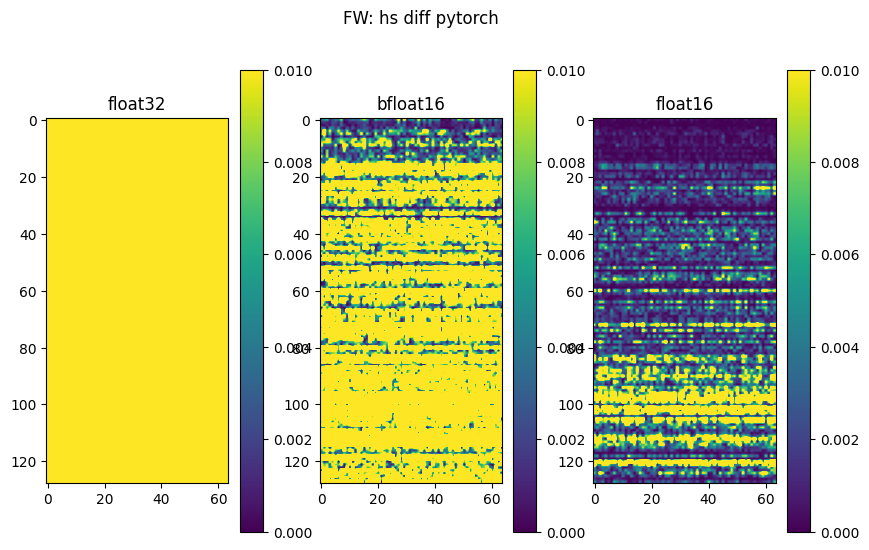

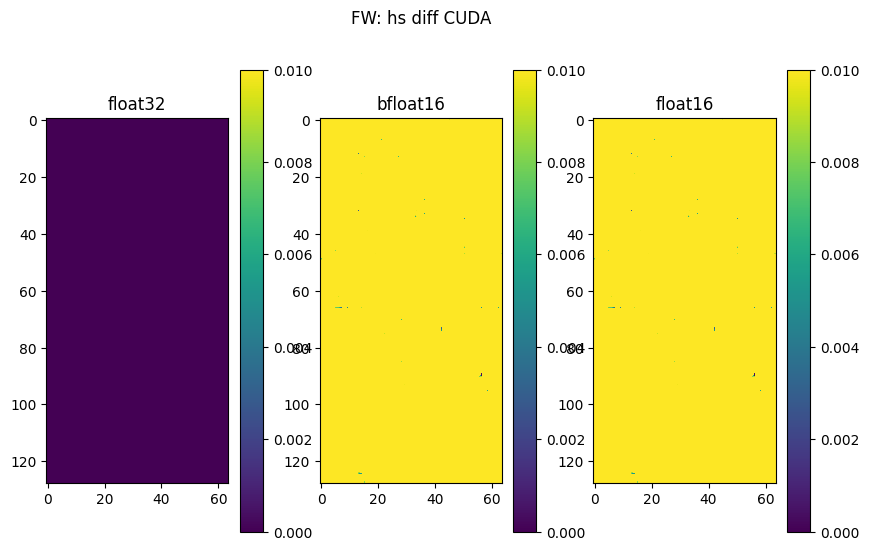

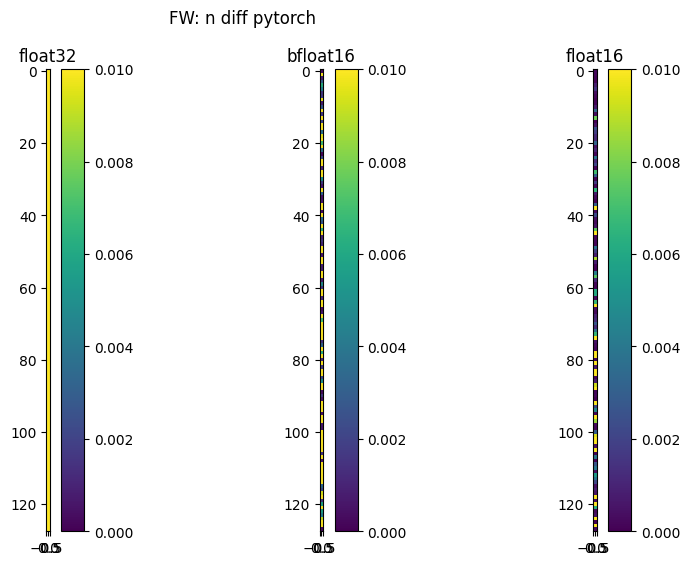

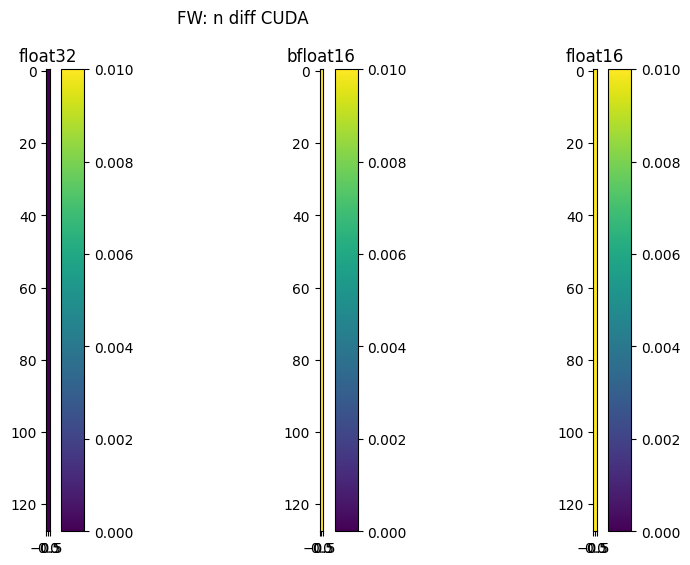

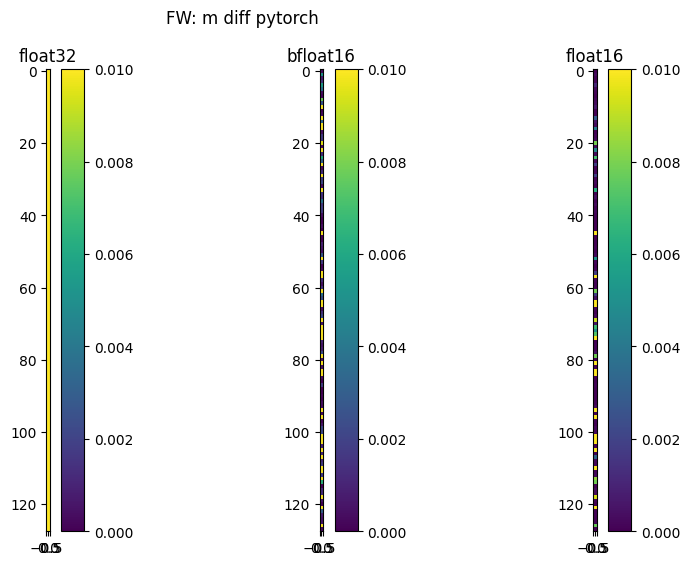

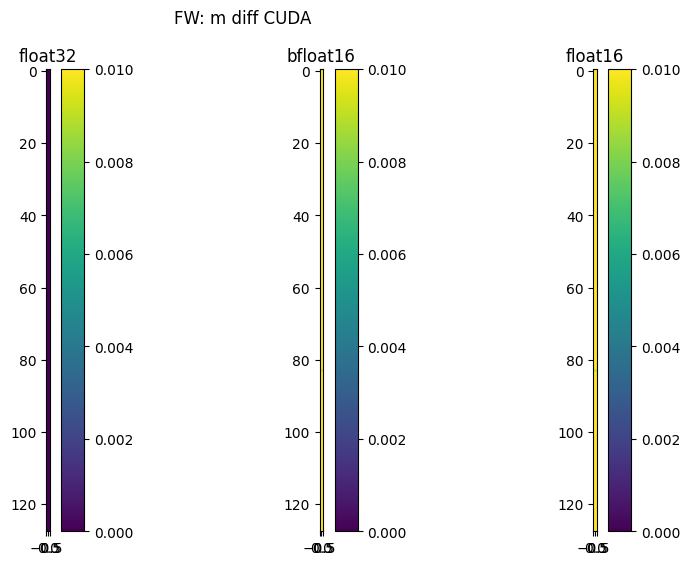

In [ ]:
## fw diffs
# hs
fig = plot_numerical_diffs(hs_pt, 10*torch.ones_like(hs_pt), hs_pt_bf16, hs_pt_half, title="FW: hs diff pytorch")
fig = plot_numerical_diffs(hs_pt, hs_cu, hs_cu_bf16, hs_cu_half, title="FW: hs diff CUDA")
# n 
fig = plot_numerical_diffs(n_pt, 10*torch.ones_like(n_pt), n_pt_bf16, n_pt_half, title="FW: n diff pytorch")
fig = plot_numerical_diffs(n_pt, n_cu, n_cu_bf16, n_cu_half, title="FW: n diff CUDA")
# m
fig = plot_numerical_diffs(m_pt, 10*torch.ones_like(m_pt), m_pt_bf16, m_pt_half, title="FW: m diff pytorch")
fig = plot_numerical_diffs(m_pt, m_cu, m_cu_bf16, m_cu_half, title="FW: m diff CUDA")